#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

#### Генерация синтетических датасетов

In [2]:
xs = np.linspace(0, 1000, 1000)
ys1 = np.sin(0.04*xs) + 0.3*np.sin(0.4*xs)
ys1[750] = 10
ys2 = np.sin(0.04*xs) + 0.3*np.sin(0.4*xs) + xs/100
ys2[735:835] = ys2[735]
ys3 = np.sin(0.04*xs)*np.sin(0.04*xs) + 0.3*np.sin(0.4*xs)
ys3[770:880] = np.abs(ys3[770:880])
ys4 = np.sin((0.04*(-(0.1*(xs-725)**2+10000)))) + 0.3*np.sin(0.4*xs)

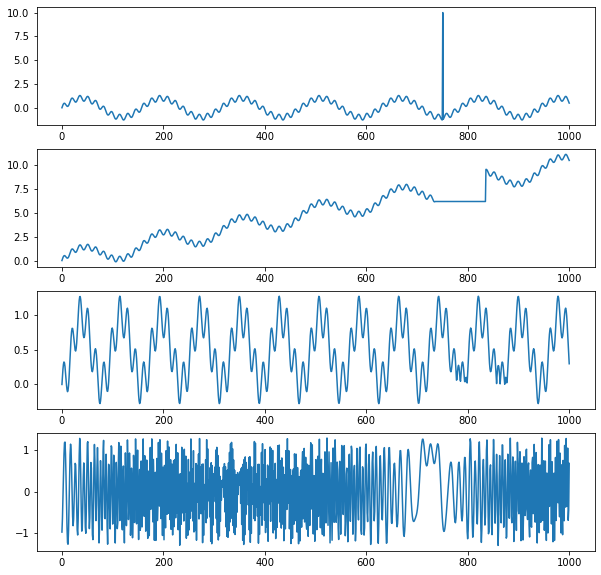

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(411);plt.plot(xs,ys1)
plt.subplot(412);plt.plot(xs,ys2)
plt.subplot(413);plt.plot(xs,ys3)
plt.subplot(414);plt.plot(xs,ys4)
plt.show()

### Приведем временные ряды к стационарному виду

In [4]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Первый ряд преобразовывать не будем

Results of Dickey-Fuller Test:
Test Statistic                  -5.136126
p-value                          0.000012
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


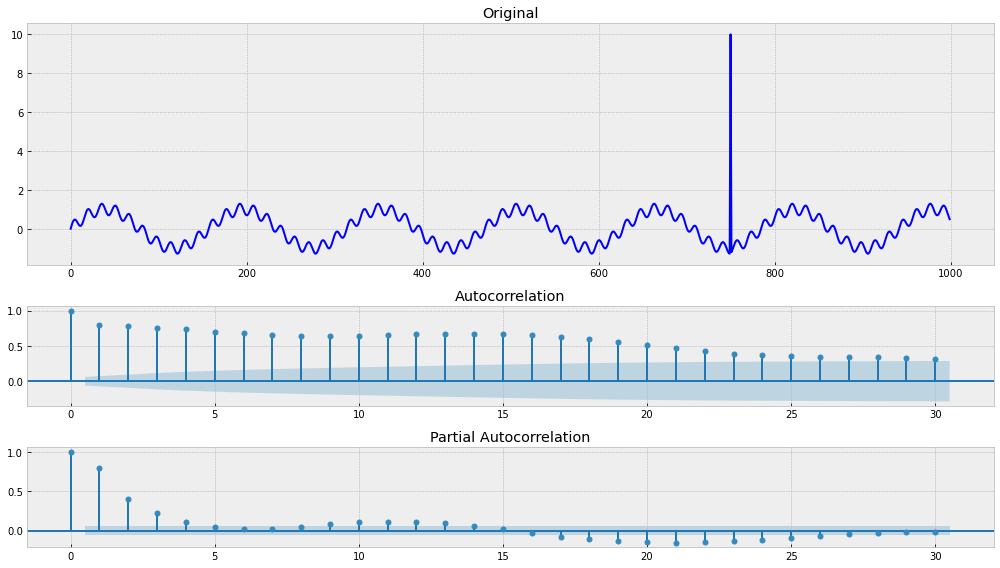

In [7]:
tsplot(ys1)

#### Второй ряд дифференцируем

Results of Dickey-Fuller Test:
Test Statistic                  -0.892290
p-value                          0.790501
#Lags Used                      18.000000
Number of Observations Used    981.000000
Critical Value (1%)             -3.437033
Critical Value (5%)             -2.864491
Critical Value (10%)            -2.568341
dtype: float64


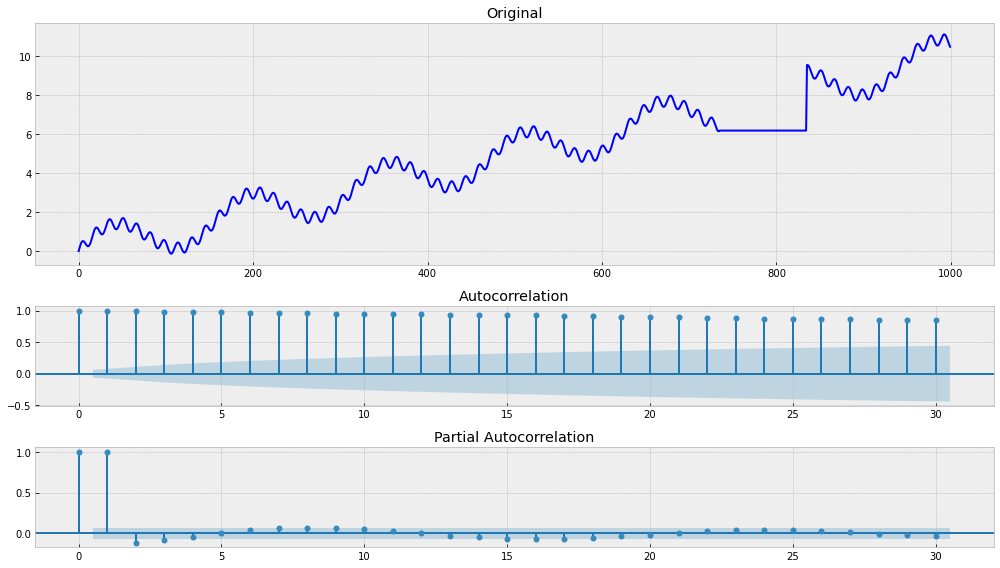

In [9]:
tsplot(ys2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.509790
p-value                          0.000189
#Lags Used                      17.000000
Number of Observations Used    981.000000
Critical Value (1%)             -3.437033
Critical Value (5%)             -2.864491
Critical Value (10%)            -2.568341
dtype: float64


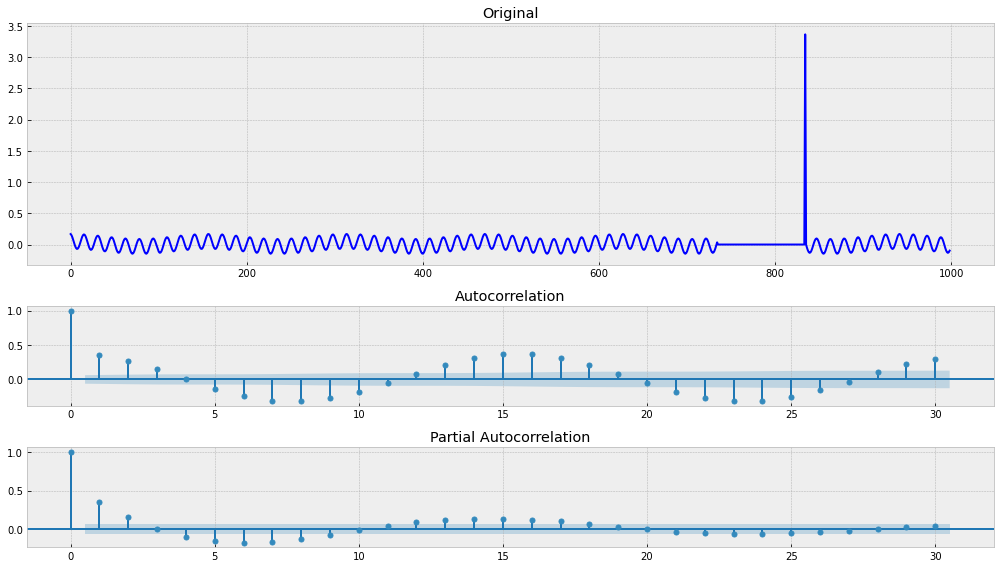

In [52]:
ys2_1 = np.diff(ys2, 1)
tsplot(ys2_1)

#### Третий и четвертый ряды без изменений

Results of Dickey-Fuller Test:
Test Statistic                -1.653460e+01
p-value                        2.009235e-29
#Lags Used                     2.100000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


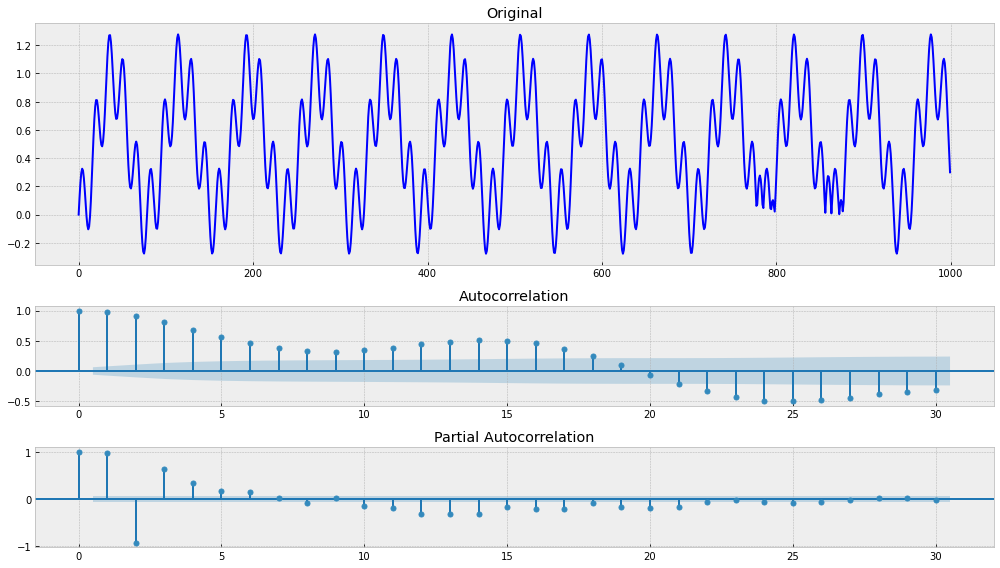

In [11]:
tsplot(ys3)

Results of Dickey-Fuller Test:
Test Statistic                 -22.327288
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


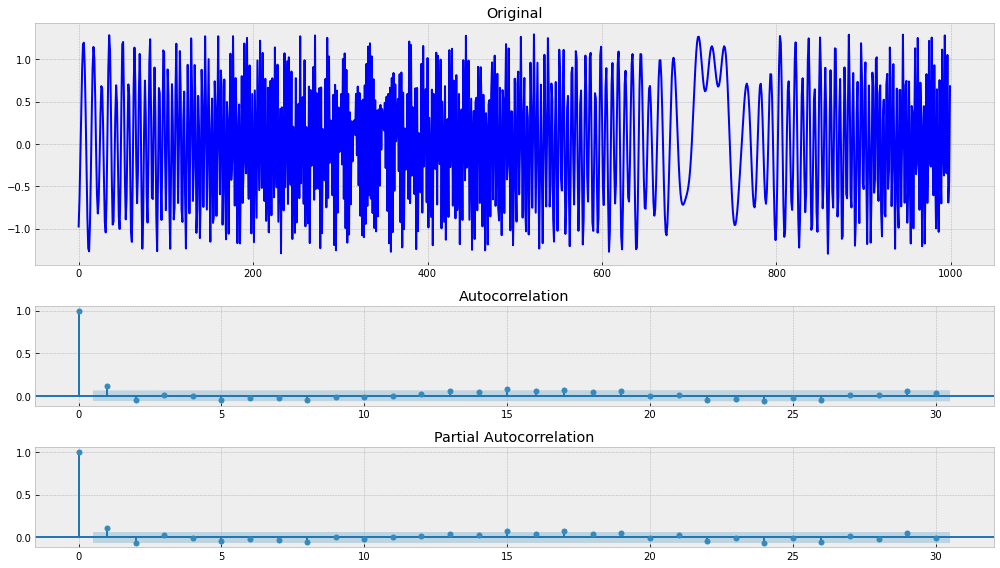

In [13]:
tsplot(ys4)

#### Подготавливаем данные

In [15]:
def create_x(arr, n_features=3):
    x, y = [], []
    for i in range(len(arr)-n_features-1):
        a = arr[i:(i+n_features)]
        x.append(a)
        y.append(arr[i + n_features])
    return np.array(x), np.array(y)

In [53]:
n_features=12
x_1, y_1 = create_x(ys1, n_features) # ys1
x_2, y_2 = create_x(ys2_1, n_features) # ys2
x_3, y_3 = create_x(ys3, n_features) # ys3
x_4, y_4 = create_x(ys4, n_features) # ys4

In [17]:
def split_data(x, y):
    num = int(len(y)*0.5)
    x_train = x[:num]
    x_test = x[num:]
    y_train = y[:num]
    y_test = y[num:]
    
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    return x_train, x_test, y_train, y_test
    

In [54]:
x1_train, x1_test, y1_train, y1_test = split_data(x_1, y_1)
x2_train, x2_test, y2_train, y2_test = split_data(x_2, y_2)
x3_train, x3_test, y3_train, y3_test = split_data(x_3, y_3)
x4_train, x4_test, y4_train, y4_test = split_data(x_4, y_4)

In [19]:
x1_train.shape

(493, 1, 12)

### LSTM_AE

In [20]:
def init_model(timesteps, n_features, num_cells=64, dropout_rate=0.1, lr=0.01):
    lstm_autoencoder = Sequential()

    # Encoder
    lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
    lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=False))
    lstm_autoencoder.add(RepeatVector(timesteps))
    # Decoder
    lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=True))
    lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', return_sequences=True))
    lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

#     lstm_autoencoder.summary()

    adam = Adam(lr)
    lstm_autoencoder.compile(loss='mse', optimizer=adam)

    cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    return lstm_autoencoder

In [21]:
def fit_model(x, model, epochs=20, batch_size=20, validation_split=0.2):
    lstm_autoencoder_history = model.fit(x, x, 
                        epochs=20, 
                        batch_size=batch_size, 
                        validation_split=0.2,
                        verbose=0, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
    return lstm_autoencoder_history

In [22]:
def plt_epoch_error(history):
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [23]:
def pred_value(model, x_train, x_test):
    predicted_train = model.predict(x_train)
    predicted_test = model.predict(x_test)

    X_train_plt = np.reshape(x_train, (x_train.shape[0], x_train.shape[2], 1))
    predict_train_plt = np.reshape(predicted_train, (predicted_train.shape[0], predicted_train.shape[2], 1))

    X_test_plt = np.reshape(x_test, (x_test.shape[0], x_test.shape[2], 1))
    predict_test_plt = np.reshape(predicted_test, (predicted_test.shape[0], predicted_test.shape[2], 1))
    
    mse = np.mean(np.power(X_test_plt- predict_test_plt, 2), axis=1)
    mse_train = np.mean(np.power(X_train_plt- predict_train_plt, 2), axis=1)
    
    return predicted_train, predicted_test, mse_train, mse

In [ ]:
def plt_mse(mse_train, mse, set_, y_test):
    plt.figure(figsize=(10,10))
    plt.subplot(411);plt.plot(mse_train);plt.title('mse_train')
    plt.subplot(412);plt.plot(mse);plt.title('mse_test')
    plt.subplot(413);plt.plot(y_test);plt.title('y_test')
    plt.subplot(414);plt.plot(set_);plt.title('y')

#### Обучаем модели для каждого набора данных. Смотрим ошибку на train и test

In [25]:
model_1 = init_model(timesteps=x1_train.shape[1], n_features=x1_train.shape[2])
history = fit_model(x1_train, model_1)
predicted_train_1, predicted_test_1, mse_train_1, mse_1 = pred_value(model_1, x1_train, x1_test)

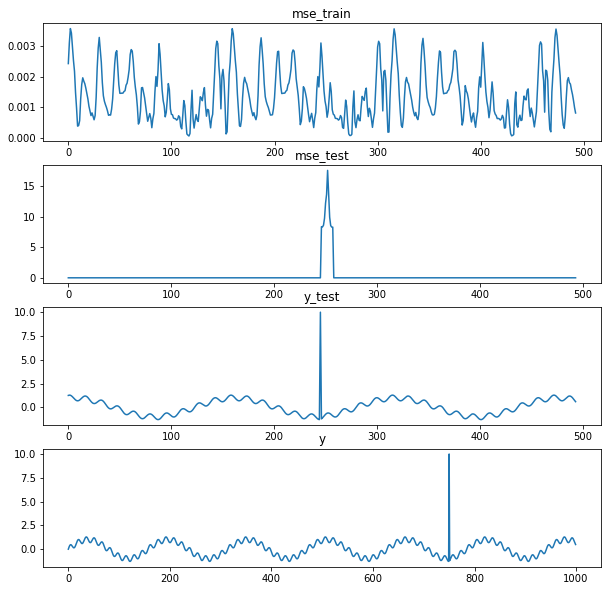

In [26]:
plt_mse(mse_train_1, mse_1, ys1, y1_test)

In [55]:
model_2 = init_model(timesteps=x2_train.shape[1], n_features=x2_train.shape[2])
history = fit_model(x2_train, model_2)
predicted_train_2, predicted_test_2, mse_train_2, mse_2 = pred_value(model_2, x2_train, x2_test)
# plt_mse(mse_train_2, mse_2, ys2)

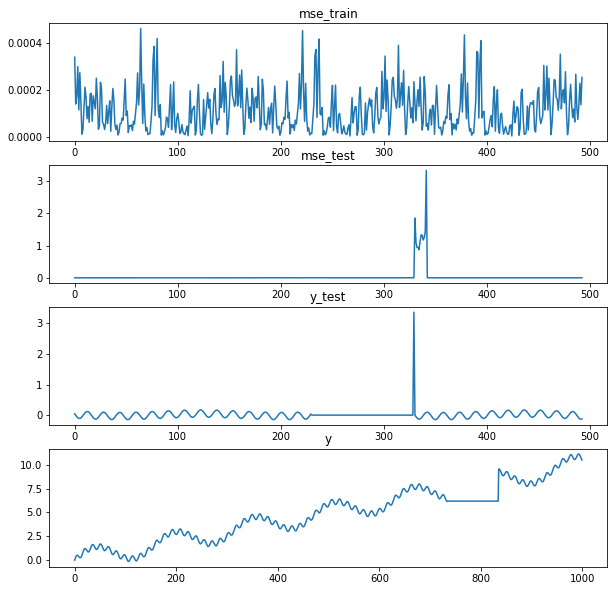

In [56]:
plt_mse(mse_train_2, mse_2, ys2, y2_test)

In [29]:
model_3 = init_model(timesteps=x3_train.shape[1], n_features=x3_train.shape[2])
history = fit_model(x3_train, model_3)
predicted_train_3, predicted_test_3, mse_train_3, mse_3 = pred_value(model_3, x3_train, x3_test)
# plt_mse(mse_train, mse, ys3)

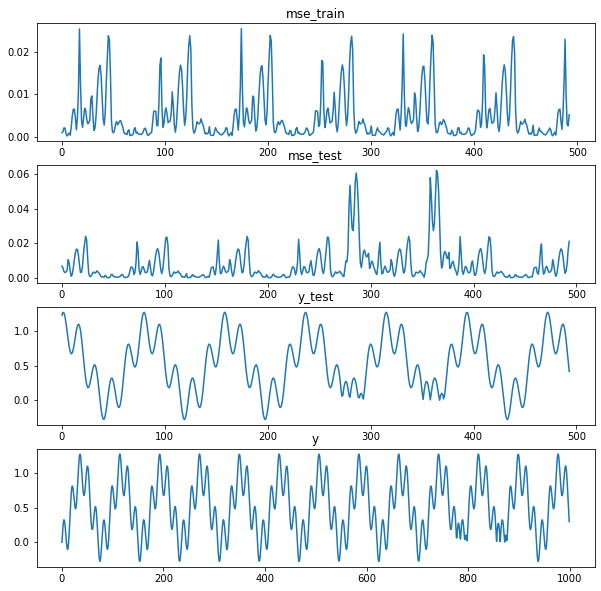

In [30]:
plt_mse(mse_train_3, mse_3, ys3, y3_test)

In [31]:
model_4 = init_model(timesteps=x4_train.shape[1], n_features=x4_train.shape[2])
history = fit_model(x4_train, model_4)
predicted_train_4, predicted_test_4, mse_train_4, mse_4 = pred_value(model_4, x4_train, x4_test)
# plt_mse(mse_train, mse, ys4)

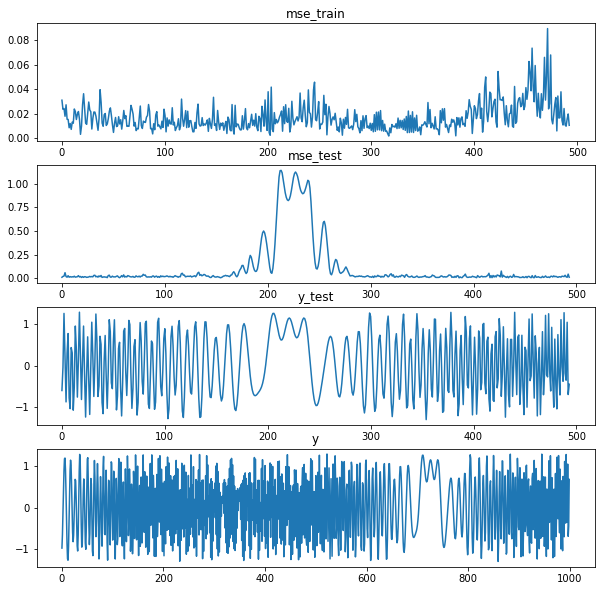

In [32]:
plt_mse(mse_train_4, mse_4, ys4, y4_test)

### Поиск аномалий OCSVM на основе LSTM_AE

In [33]:
from sklearn import svm

In [34]:
def get_anomalies(x_train, x_test, pred_train, pred_test):
    # Создаем обучающие данные на основе ошибки прдесказания на Train     
    e = x_train-pred_train
    nsamples, nx, ny = e.shape
    d2_e = e.reshape((nsamples,nx*ny))
    
    # Создаем модель и обучаем     
    clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
    clf.fit(d2_e)
    
    # Предсказываем класс для данных ошибки предсказания на Test     
    e_t=x_test - pred_test
    nsamples, nx, ny = e_t.shape
    d2_e_t = e_t.reshape((nsamples,nx*ny))
    
    y_scores = clf.predict(d2_e_t)
    return y_scores

In [35]:
def plot_anomalies(anm, y_test):
    arr = []
    for i in range(len(y_test)):
        if anm[i] == 1:
            arr.append(None)
        else:
            arr.append(y_test[i])
    
    plt.figure(figsize=(12,6))
    plt.plot(y_test)
    plt.plot(arr, color='r')
    plt.show()

#### Ищем аномалии для каждого набора данных

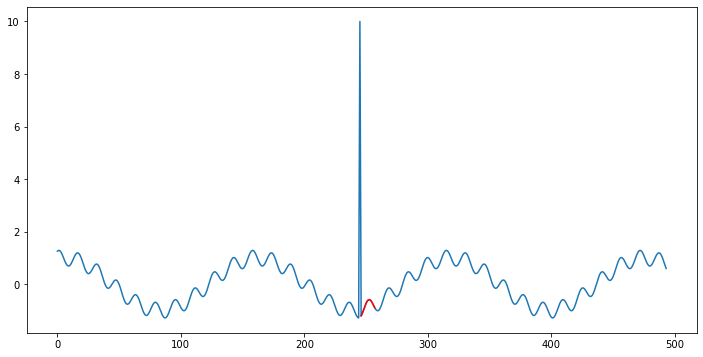

In [36]:
anomalies_1 = get_anomalies(x1_train, x1_test, predicted_train_1, predicted_test_1)
plot_anomalies(anomalies_1, y1_test)

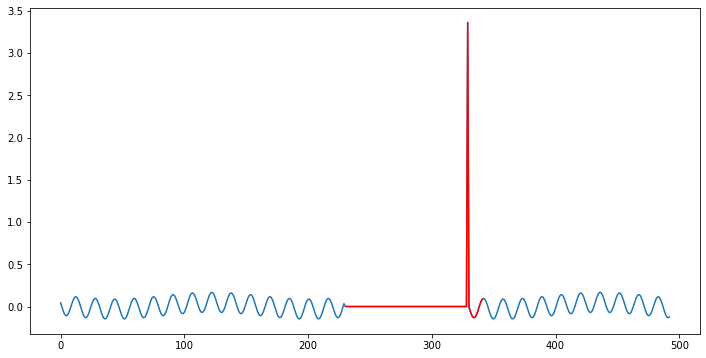

In [57]:
anomalies_2 = get_anomalies(x2_train, x2_test, predicted_train_2, predicted_test_2)
plot_anomalies(anomalies_2, y2_test)

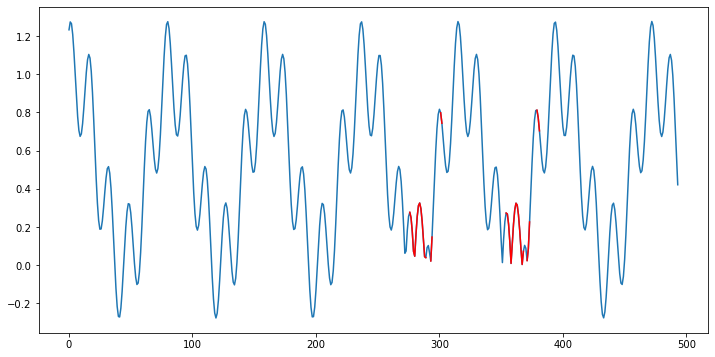

In [40]:
anomalies_3 = get_anomalies(x3_train, x3_test, predicted_train_3, predicted_test_3)
plot_anomalies(anomalies_3, y3_test)

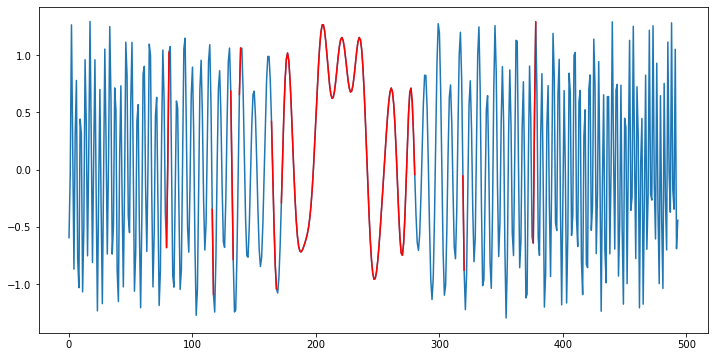

In [41]:
anomalies_4 = get_anomalies(x4_train, x4_test, predicted_train_4, predicted_test_4)
plot_anomalies(anomalies_4, y4_test)